In [27]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import iqr
import warnings
warnings.filterwarnings('ignore')

In [28]:
def extract_time(json):
    try:
        # Also convert to int since update_time will be string.  When comparing
        # strings, "10" is smaller than "2".
        return int(json['content']['timestamp'])
    except KeyError:
        return 0

In [29]:
data = []
for d, s, f in os.walk("/Users/jeremypcleung/coding-analytics/2018"):
    for file in f:
        if "." not in file:
            current_file=open(os.path.join(d, file))
            for line in current_file:
                if len(line) > 1:
                    data.append(json.JSONDecoder().decode(line))

data.sort(key=extract_time)
                    
with open('data-all.json', 'w') as outfile:
    json.dump(data, outfile)

In [483]:
users = {}
for entry in data:
    if entry["user_id"] not in users:
        users[entry["user_id"]] = []
    users[entry["user_id"]].append(entry)

In [510]:
details = {}

for user_id in users:
    for index in range(len(users[user_id])):
        if users[user_id][index]["content"]["action"] == "Start" and user_id != '0' and user_id != '427':
            current = True
            stage_id = users[user_id][index]["content"]["stage_id"]
            if user_id not in details:
                details[user_id] = {}
            if stage_id not in details[user_id]:
                details[user_id][stage_id] = {"numRuns": 0, "totalDuration": 0, "startToGet": [], "startToRun": [], "numResets": 0, "success": [], "getToPut": []}
            startTime = int(users[user_id][index]["content"]["timestamp"])
            getTime = 0
            runTime = 0
            while(current):
                index += 1
                if len(users[user_id]) != index and ("stage_id" in users[user_id][index]["content"] and users[user_id][index]["content"]["stage_id"] == stage_id):
                    if int(users[user_id][index]["content"]["timestamp"]) - int(users[user_id][index-1]["content"]["timestamp"]) > 3600000:
                        endTime = int(users[user_id][index-1]["content"]["timestamp"])
                        details[user_id][stage_id]["totalDuration"] += endTime - startTime
                        startTime = int(users[user_id][index]["content"]["timestamp"])
                if len(users[user_id]) == index or ("stage_id" in users[user_id][index]["content"] and users[user_id][index]["content"]["stage_id"] != stage_id):
                    current = False
                    endTime = int(users[user_id][index-1]["content"]["timestamp"])
                    details[user_id][stage_id]["totalDuration"] += endTime - startTime
                    details[user_id][stage_id]["success"].append(0)
                elif users[user_id][index]["content"]["action"] == "Default":
                    current = False
                    endTime = int(users[user_id][index-1]["content"]["timestamp"])
                    details[user_id][stage_id]["totalDuration"] += endTime - startTime
                    details[user_id][stage_id]["success"].append(0)
                elif users[user_id][index]["content"]["action"] == "Win":
                    current = False
                    endTime = int(users[user_id][index]["content"]["timestamp"])
                    details[user_id][stage_id]["totalDuration"] += endTime - startTime
                    details[user_id][stage_id]["success"].append(1)
                elif users[user_id][index]["content"]["action"] == "Leave":
                    current = False
                    endTime = int(users[user_id][index]["content"]["timestamp"])
                    details[user_id][stage_id]["totalDuration"] += endTime - startTime
                    details[user_id][stage_id]["success"].append(0)
                elif users[user_id][index]["content"]["action"] == "Get":
                    if getTime == 0:
                        getTime = int(users[user_id][index]["content"]["timestamp"])
                        details[user_id][stage_id]["startToGet"].append(getTime-startTime)
                    getTime = int(users[user_id][index]["content"]["timestamp"])
                elif users[user_id][index]["content"]["action"] == "Put":
                    putTime = int(users[user_id][index]["content"]["timestamp"])
                    if putTime-getTime < 1800000:
                        details[user_id][stage_id]["getToPut"].append(putTime-getTime)
                elif users[user_id][index]["content"]["action"] == "Run":
                    details[user_id][stage_id]["numRuns"] += 1
                    if runTime == 0:
                        runTime = int(users[user_id][index]["content"]["timestamp"])
                        details[user_id][stage_id]["startToRun"].append(runTime-startTime)
                elif users[user_id][index]["content"]["action"] == "Reset":
                    details[user_id][stage_id]["numResets"] += 1

{'numRuns': 4, 'totalDuration': 103803, 'startToGet': [18167, 10829, 12145], 'startToRun': [12555, 35963, 15314], 'numResets': 1, 'success': [1, 1, 0], 'getToPut': [1284, 568, 701, 668, 934, 586, 767, 735, 534, 635, 568, 1168, 834, 734, 2168, 1936, 901, 534, 568, 802]}


In [485]:
delete = set()
didNotPlay = []

for index, user_id in enumerate(details):
    for i, stage_id in enumerate(details[user_id]):
        if len(details[user_id][stage_id]["startToGet"])==0 or len(details[user_id][stage_id]["startToRun"])==0 or len(details[user_id][stage_id]["getToPut"])==0 or details[user_id][stage_id]["totalDuration"] == 0:
            delete.add(stage_id)
        if (len(details[user_id][stage_id]["startToGet"])==0 or len(details[user_id][stage_id]["startToRun"])==0 or len(details[user_id][stage_id]["getToPut"])==0) and details[user_id][stage_id]["totalDuration"] != 0:
            didNotPlay.append(user_id+":"+stage_id)
    for d in delete:
        del details[user_id][d]       
    delete = set()

for index, user_id in enumerate(details):
    if len(details[user_id]) == 0:
        delete.add(user_id)

for d in delete:
        del details[d]

In [511]:
processed_stats = {}
for index, user_id in enumerate(details):
    if user_id not in processed_stats:
        processed_stats[user_id] = {}
    for i, stage_id in enumerate(details[user_id]):
        if stage_id not in processed_stats[user_id]:
            processed_stats[user_id][stage_id] = {}
        processed_stats[user_id][stage_id]["numRuns"] = details[user_id][stage_id]["numRuns"]
        processed_stats[user_id][stage_id]["totalDuration"] = details[user_id][stage_id]["totalDuration"]
        processed_stats[user_id][stage_id]["startToGet"] = np.average(details[user_id][stage_id]["startToGet"])
        processed_stats[user_id][stage_id]["startToRun"] = np.average(details[user_id][stage_id]["startToRun"])
        processed_stats[user_id][stage_id]["numResets"] = details[user_id][stage_id]["numResets"]
        processed_stats[user_id][stage_id]["success"] = np.average(details[user_id][stage_id]["success"])
        processed_stats[user_id][stage_id]["getToPut"] = np.average(details[user_id][stage_id]["getToPut"])

{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}


In [512]:
level_stats = {}
levels_list = set()
for user_id, stages in processed_stats.items():
    for stage_id, info in stages.items():
        levels_list.add(stage_id)
        if stage_id not in level_stats:
            level_stats[stage_id] = {}
        level_stats[stage_id][user_id] = info

delete = []
for stage_id, levels in level_stats.items():
    if len(levels) < 10:
        delete.append(stage_id)
        
for d in delete:
    del level_stats[d]
    levels_list.remove(d)
levels_list = list(levels_list)

{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}


In [513]:
user_stats = {}
users_list = set()
for stage_id, levels in level_stats.items():
    for user_id, info in levels.items():
        users_list.add(user_id)
        if user_id not in user_stats:
            user_stats[user_id] = {}
        user_stats[user_id][stage_id] = info
users_list = list(users_list)

{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}


In [514]:
original_stats = np.empty((len(users_list),len(levels_list)*7))
original_stats.fill(np.nan)
for index, user_id in enumerate(user_stats):
    for i, stage_id in enumerate(levels_list):
        if stage_id in user_stats[user_id]:
            original_stats[index][0+i*7] = user_stats[user_id][stage_id]['numRuns']
            original_stats[index][1+i*7] = user_stats[user_id][stage_id]['totalDuration']
            original_stats[index][2+i*7] = user_stats[user_id][stage_id]['startToGet']
            original_stats[index][3+i*7] = user_stats[user_id][stage_id]['startToRun']
            original_stats[index][4+i*7] = user_stats[user_id][stage_id]['numResets']
            original_stats[index][5+i*7] = user_stats[user_id][stage_id]['success']
            original_stats[index][6+i*7] = user_stats[user_id][stage_id]['getToPut']
        print(user_stats['4899']['23'])
        
columns = ["Number of Runs", "Total Duration", "Start to first Get Time", "Start to first Run Time", "Number of Resets", "Success Rate", "Get to Put Time"]
users_df = pd.DataFrame(original_stats, index=users_list, columns=np.tile(columns,len(levels_list)))

{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets':

{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets':

{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets':

{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets':

{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets':

{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets': 1, 'success': 0.66666666666666663, 'getToPut': 881.25}
{'numRuns': 4, 'totalDuration': 103803, 'startToGet': 13713.666666666666, 'startToRun': 21277.333333333332, 'numResets':

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [490]:
levels_info = {}
for stage_id, levels in level_stats.items():
    levels_info[stage_id] = np.zeros((len(levels),8))
    for index, user_id in enumerate(levels):
        levels_info[stage_id][index][0] = level_stats[stage_id][user_id]['numRuns']
        levels_info[stage_id][index][1] = level_stats[stage_id][user_id]['totalDuration']
        levels_info[stage_id][index][2] = level_stats[stage_id][user_id]['startToGet']
        levels_info[stage_id][index][3] = level_stats[stage_id][user_id]['startToRun']
        levels_info[stage_id][index][4] = level_stats[stage_id][user_id]['numResets']
        levels_info[stage_id][index][5] = level_stats[stage_id][user_id]['success']
        levels_info[stage_id][index][6] = level_stats[stage_id][user_id]['getToPut']
        levels_info[stage_id][index][7] = user_id

In [491]:
norm_level = levels_info.copy()
for stage_id, level in norm_level.items():
    scaler = MinMaxScaler()
    norm_level[stage_id] = scaler.fit_transform(level)
    for index, normVal in enumerate(norm_level[stage_id]):
        for i in range(7):
            levels_info[stage_id][index][i] = norm_level[stage_id][index][i]

In [492]:
users_info = {}
for stage_id, level in levels_info.items():
    for index, user in enumerate(level):
        user_id = str(int(levels_info[stage_id][index][7]))
        if user_id not in users_info:
            users_info[user_id] = {}
            users_info[user_id]['numRuns'] = []
            users_info[user_id]['totalDuration'] = []
            users_info[user_id]['startToGet'] = []
            users_info[user_id]['startToRun'] = []
            users_info[user_id]['numResets'] = []
            users_info[user_id]['success'] = []
            users_info[user_id]['getToPut'] = []
        users_info[user_id]['numRuns'].append(levels_info[stage_id][index][0])
        users_info[user_id]['totalDuration'].append(levels_info[stage_id][index][1])
        users_info[user_id]['startToGet'].append(levels_info[stage_id][index][2])
        users_info[user_id]['startToRun'].append(levels_info[stage_id][index][3])
        users_info[user_id]['numResets'].append(levels_info[stage_id][index][4])
        users_info[user_id]['success'].append(levels_info[stage_id][index][5])
        users_info[user_id]['getToPut'].append(levels_info[stage_id][index][6])

In [493]:
stats = np.empty((len(users_info),7))
for index, user_id in enumerate(users_info):
    stats[index][0] = np.average(users_info[user_id]['numRuns'])
    stats[index][1] = np.average(users_info[user_id]['totalDuration'])
    stats[index][2] = np.average(users_info[user_id]['startToGet'])
    stats[index][3] = np.average(users_info[user_id]['startToRun'])
    stats[index][4] = np.average(users_info[user_id]['startToRun'])
    stats[index][5] = np.average(users_info[user_id]['success'])
    stats[index][6] = np.average(users_info[user_id]['getToPut'])

In [494]:
columns = ["Number of Runs", "Total Duration", "Start to first Get Time", "Start to first Run Time", "Number of Resets", "Success Rate", "Get to Put Time"]
average_df = pd.DataFrame(stats, index=users_list, columns=columns)

In [495]:
norm_stats = stats.copy()
norm_stats = np.reshape(norm_stats[:,:7],(len(norm_stats),7))
scaler = MinMaxScaler()
norm_stats = scaler.fit_transform(norm_stats)

In [496]:
kmeans = KMeans(n_clusters=4, n_init=10, max_iter=300, tol=1e-4)
pca = PCA(n_components=2).fit(norm_stats)
norm_stats = pca.transform(norm_stats)
stats_predictions = kmeans.fit_predict(norm_stats)

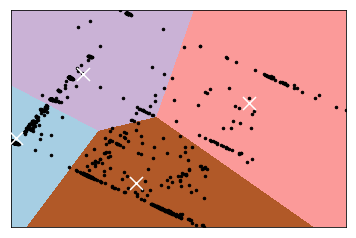

In [497]:
# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = norm_stats[:, 0].min(), norm_stats[:, 0].max()
y_min, y_max = norm_stats[:, 1].min(), norm_stats[:, 1].max()

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = ((x_max-x_min)/5000 + (y_max-y_min)/5000)/2     # point in the mesh [x_min, x_max]x[y_min, y_max].

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(norm_stats[:, 0], norm_stats[:, 1], 'k.', markersize=5)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [498]:
users_df['Group'] = stats_predictions
users_df.to_csv("users-groups.csv", sep=',')

In [501]:
average_df['Group'] = stats_predictions
average_df.to_csv("average-groups.csv", sep=',')